<a href="https://colab.research.google.com/github/matheustoneti/MachinePredictiveMaintenanceClassification/blob/main/Machine_Predictive_Maintenance_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from mlflow import MlflowClient
from pprint import pprint



In [4]:
# In order to connect to the tracking server, we’ll need to use the uri that we assigned the server when we started it.

client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

#it allows programmatic interaction with the MLflow tracking server.


all_experiments = client.search_experiments()

print(all_experiments)



[<Experiment: artifact_location='mlflow-artifacts:/664358845760291567', creation_time=1725816755321, experiment_id='664358845760291567', last_update_time=1725816755321, lifecycle_stage='active', name='Loan_Default_Prediction_Models', tags={'industry': 'finance',
 'mlflow.note.content': 'This is the loan default prediction project. This '
                        'experiment analyzes credit risk for loan default '
                        'predictions.',
 'project_name': 'loan-default-prediction',
 'project_quarter': 'Q9-2024',
 'team': 'risk-analysis-ml'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1725798393941, experiment_id='0', last_update_time=1725798393941, lifecycle_stage='active', name='Default', tags={}>]


In [5]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the loan default prediction project. "
    "This experiment analyzes credit risk for loan default predictions."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "loan-default-prediction",
    "industry": "finance",
    "team": "risk-analysis-ml",
    "project_quarter": "Q9-2024",
    "mlflow.note.content": experiment_description,
}

try:
    # Create the Experiment, providing a unique name
    loan_default_experiment = client.create_experiment(
        name="Loan_Default_Prediction_Models", tags=experiment_tags
    )
except:
    print("RESOURCE_ALREADY_EXISTS: Experiment 'Loan_Default_Prediction_Models' already exists.")



RESOURCE_ALREADY_EXISTS: Experiment 'Loan_Default_Prediction_Models' already exists.


In [6]:
# Use search_experiments() to search on the project_name tag key
loan_default_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'loan-default-prediction'"
)

print(vars(loan_default_experiment[0]))


{'_experiment_id': '664358845760291567', '_name': 'Loan_Default_Prediction_Models', '_artifact_location': 'mlflow-artifacts:/664358845760291567', '_lifecycle_stage': 'active', '_tags': {'mlflow.note.content': 'This is the loan default prediction project. This experiment analyzes credit risk for loan default predictions.', 'project_name': 'loan-default-prediction', 'industry': 'finance', 'team': 'risk-analysis-ml', 'project_quarter': 'Q9-2024'}, '_creation_time': 1725816755321, '_last_update_time': 1725816755321}


In [7]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [8]:
# This function call sets the global tracking URI for the current session.
# It’s a convenient way to configure the tracking server URI without creating a separate client instance.

mlflow.set_tracking_uri("http://127.0.0.1:5000")


In [9]:
# Sets the current active experiment to the "Loan_Default_Prediction_Models" experiment
# and returns the Experiment metadata
loan_experiment = mlflow.set_experiment("Loan_Default_Prediction_Models")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "loan_rf_test"

# Define an artifact path that the model will be saved to.
artifact_path = "rf_loan_model"


In [10]:
data = pd.read_csv('Loan_Data.csv')

In [11]:
data.head(100)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
95,5699479,5,3840.418321,14994.265440,53794.32662,1,555,1
96,4675595,2,3670.925710,9596.226460,75718.62338,8,687,0
97,2061413,0,2038.609652,2984.174167,42878.60520,6,625,0
98,7431458,0,2914.249997,917.311108,64879.74563,5,581,0


In [12]:
data = data.drop(['customer_id'], axis=1)


In [13]:
# Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
 6   default                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 547.0 KB


In [14]:
dataF = (data['default'] == 1).sum()
dataN = (data['default'] == 0).sum()
total = dataN + dataF
print(f"{dataF} ({100*dataF/total:.2f}%) customers who actually missed their payments")
print(f"{dataN} ({100*dataN/total:.2f}%) customers who did not missed their payments")

1851 (18.51%) customers who actually missed their payments
8149 (81.49%) customers who did not missed their payments


In [15]:
data


,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,5221.545193,3915.471226,78039.38546,5,605,0
1,5,1958.928726,8228.752520,26648.43525,2,572,1
2,0,3363.009259,2027.830850,65866.71246,4,602,0
3,0,4766.648001,2501.730397,74356.88347,5,612,0
4,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...
9995,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,0,3288.901666,1043.099660,50929.37206,2,647,0


In [16]:
### function thats plot a model score and seves the best model
import numpy as np
import matplotlib.pyplot as plt 
import pickle

def selectAndPlot(info):
    max=0.0
    index= -1
    for i in range(len(info)):
        if(max < info[i]["score"]):
            max = info[i]["score"]
            index = i
    
    
    #Save model
    with open('model.pkl', 'wb') as f:
        pickle.dump(info[index]["model"], f)
    
    
    plt.figure(figsize = (10, 5))
    modelName = [item["modelName"] for item in info]
    modelScore = [item["score"] for item in info]
    plt.bar(modelName, modelScore, color ='maroon', width = 0.4)
    plt.title("Model Scores")
    plt.xlabel("Model Name")
    plt.ylabel("Model score")
    plt.show()
    

            
    

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
 6   default                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 547.0 KB


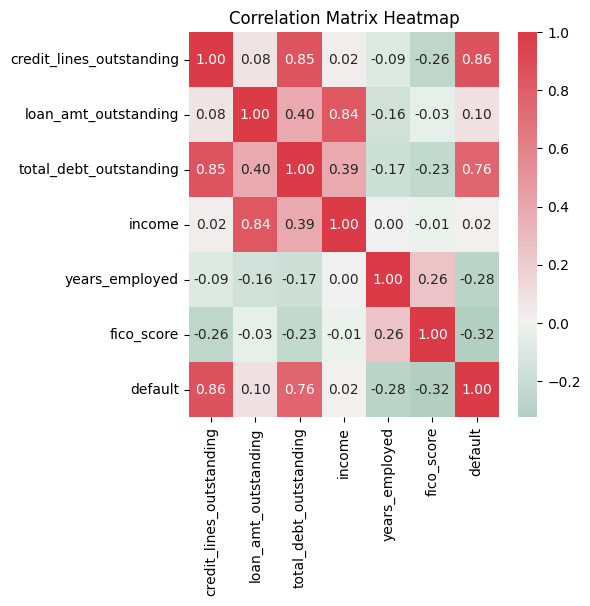

In [18]:
df = pd.DataFrame(data)
#df.drop('Failure Type', axis=1, inplace=True)

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a figure and axes with a specific size
fig, ax = plt.subplots(figsize=(5, 5))

# Create a custom colormap from green (low correlation) to red (high correlation)
cmap = sns.diverging_palette(150, 10, as_cmap=True)

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, center=0, ax=ax)

# Set the title
ax.set_title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

In [19]:
data_pair_plot = data[['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score',"default"]]

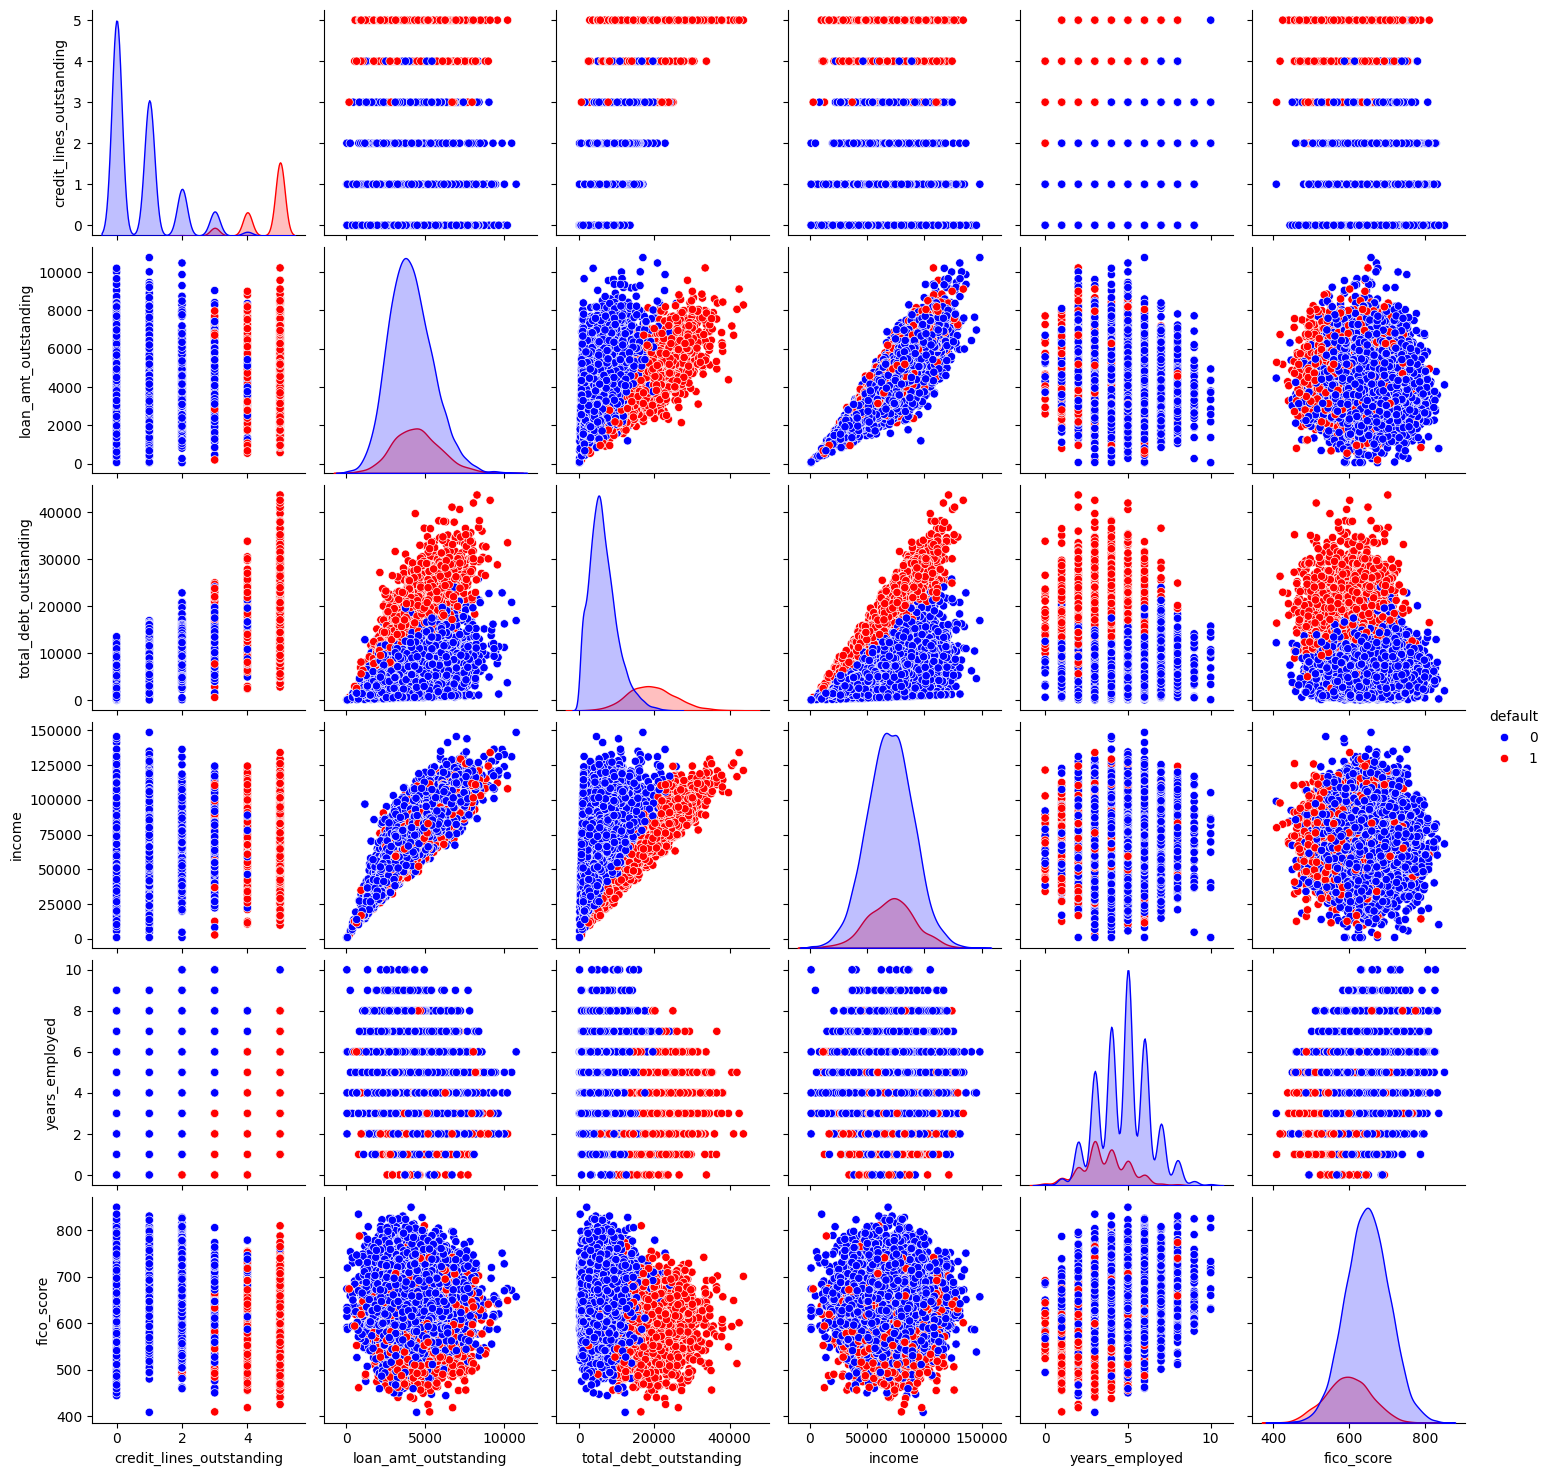

In [20]:
# Define a custom palette
custom_palette = {0: "blue", 1: "red"}

# Create the pairplot with the custom palette
sns.pairplot(data=data_pair_plot, hue='default', palette=custom_palette)

In [21]:
#data.head(50)# Assuming df is your DataFrame
print(data.dtypes)


credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object


In [22]:
modelResult = []

In [23]:
y = data['default']
x = data.drop(['default'], axis = 1)

In [24]:
x.head(10)


,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
0,0,5221.545193,3915.471226,78039.38546,5,605
1,5,1958.928726,8228.752520,26648.43525,2,572
2,0,3363.009259,2027.830850,65866.71246,4,602
3,0,4766.648001,2501.730397,74356.88347,5,612
4,1,1345.827718,1768.826187,23448.32631,6,631
5,0,5376.886873,7189.121298,85529.84591,2,697
6,1,3634.057471,7085.980095,68691.57707,6,722
7,4,3302.172238,13067.570210,50352.16821,3,545
8,0,2938.325123,1918.404472,53497.37754,4,676
9,0,5396.366774,5298.824524,92349.55399,2,447


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = (0.3))

In [26]:
modelo = GradientBoostingClassifier()
modelo = modelo.fit(x_train, y_train)
accuracy = modelo.score(x_test, y_test)
print(accuracy)
modelResult.append({"score" : accuracy , "model" : modelo, "modelName": "GradientBoostingClassifier" })


0.997


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc


import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Initialize and train the model
model_RandomForestClassifier = RandomForestClassifier(class_weight='balanced', random_state=42)
model_RandomForestClassifier.fit(x_train, y_train)

# Predictions
y_probs = model_RandomForestClassifier.predict_proba(x_test)[:, 1]
y_pred = model_RandomForestClassifier.predict(x_test)

# Evaluation
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_probs)
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

# Store metrics for MLflow logging
metrics = {
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
}

# Store model parameters for MLflow logging
params = {
    "class_weight": 'balanced',
    "random_state": 42,
}

# Define the artifact path and run name
artifact_path = "rf_classification_model"
run_name = "RandomForestClassifier_Loan_Default"

# Start an MLflow run and log model, parameters, and metrics
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model
    mlflow.log_params(params)

    # Log evaluation metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)

    # Log classification report (optional - log as a text artifact)
    report = classification_report(y_test, y_pred, output_dict=True)
    mlflow.log_dict(report, "classification_report.json")

    # Log model to MLflow
    mlflow.sklearn.log_model(
        sk_model=model_RandomForestClassifier, 
        artifact_path=artifact_path
    )

# Optionally append the result to your modelResult list
modelResult.append({"score": roc_auc, "model": model_RandomForestClassifier, "modelName": "RandomForestClassifier"})


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2434
           1       0.99      0.98      0.99       566

    accuracy                           1.00      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000

ROC-AUC Score: 0.9998
Precision-Recall AUC Score: 0.9993


2024/09/08 19:47:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/08 19:47:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForestClassifier_Loan_Default at: http://127.0.0.1:5000/#/experiments/664358845760291567/runs/d0f7056606254752946421ea5bd113b0.
2024/09/08 19:47:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/664358845760291567.


In [29]:
import mlflow
import mlflow.sklearn
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Initialize and train the model
model_CatBoostClassifier = CatBoostClassifier(class_weights=[1, 97], random_state=42)
model_CatBoostClassifier.fit(x_train, y_train)

# Predictions
y_probs = model_CatBoostClassifier.predict_proba(x_test)[:, 1]
y_pred = model_CatBoostClassifier.predict(x_test)

# Evaluation
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_probs)
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

# Store metrics for MLflow logging
metrics = {
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
}

# Store model parameters for MLflow logging
params = {
    "class_weights": [1, 97],
    "random_state": 42,
}

# Define the artifact path and run name
artifact_path = "catboost_classification_model"
run_name = "CatBoostClassifier_Loan_Default"

# Start an MLflow run and log model, parameters, and metrics
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model
    mlflow.log_params(params)

    # Log evaluation metrics
    mlflow.log_metrics(metrics)

    # Log classification report (optional - log as a text artifact)
    report = classification_report(y_test, y_pred, output_dict=True)
    mlflow.log_dict(report, "classification_report.json")

    # Log model to MLflow
    mlflow.sklearn.log_model(
        sk_model=model_CatBoostClassifier, 
        artifact_path=artifact_path
    )

# Optionally append the result to your modelResult list
modelResult.append({"score": roc_auc, "model": model_CatBoostClassifier, "modelName": "CatBoostClassifier"})


Learning rate set to 0.023648
0:	learn: 0.6345281	total: 57.3ms	remaining: 57.2s
1:	learn: 0.5711834	total: 66ms	remaining: 32.9s
2:	learn: 0.5313467	total: 74ms	remaining: 24.6s
3:	learn: 0.4978175	total: 82.5ms	remaining: 20.5s
4:	learn: 0.4661187	total: 90.8ms	remaining: 18.1s
5:	learn: 0.4207588	total: 98.8ms	remaining: 16.4s
6:	learn: 0.3809741	total: 107ms	remaining: 15.1s
7:	learn: 0.3460013	total: 115ms	remaining: 14.3s
8:	learn: 0.3048933	total: 123ms	remaining: 13.6s
9:	learn: 0.2778030	total: 131ms	remaining: 13s
10:	learn: 0.2572497	total: 139ms	remaining: 12.5s
11:	learn: 0.2350298	total: 146ms	remaining: 12s
12:	learn: 0.2133581	total: 154ms	remaining: 11.7s
13:	learn: 0.1949988	total: 162ms	remaining: 11.4s
14:	learn: 0.1823156	total: 168ms	remaining: 11s
15:	learn: 0.1686089	total: 174ms	remaining: 10.7s
16:	learn: 0.1524486	total: 183ms	remaining: 10.6s
17:	learn: 0.1432759	total: 192ms	remaining: 10.5s
18:	learn: 0.1302478	total: 202ms	remaining: 10.4s
19:	learn: 0.12

2024/09/08 20:18:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/08 20:18:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run CatBoostClassifier_Loan_Default at: http://127.0.0.1:5000/#/experiments/664358845760291567/runs/a3c3a58a29a64589b4c5ea60775e737f.
2024/09/08 20:18:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/664358845760291567.


In [31]:
import mlflow
import mlflow.tensorflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Start MLflow run
run_name = "Neural_Network_Loan_Prediction"
with mlflow.start_run(run_name=run_name) as run:
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Building the neural network model
    model_NN = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
        Dense(32, activation='relu'),  # Second hidden layer
        Dense(1, activation='sigmoid')  # Output layer
    ])

    # Compiling the model
    model_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Log the model structure and parameters
    mlflow.log_params({
        "optimizer": "adam",
        "loss_function": "binary_crossentropy",
        "batch_size": 10,
        "epochs": 50,
        "input_dim": X_train.shape[1],
        "layer1_units": 64,
        "layer2_units": 32,
        "output_activation": "sigmoid"
    })

    # Training the model
    history = model_NN.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

    # Evaluating the model
    loss, accuracy = model_NN.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Log the accuracy and loss
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_loss", loss)

    # Making predictions
    y_probs = model_NN.predict(X_test).flatten()  # Predict probabilities
    y_pred = (y_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Print classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Log classification report
    mlflow.log_dict(report, "classification_report_nn.json")

    # Calculate and print ROC-AUC
    roc_auc = roc_auc_score(y_test, y_probs)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Log ROC-AUC
    mlflow.log_metric("roc_auc", roc_auc)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

    # Log Precision-Recall AUC
    mlflow.log_metric("precision_recall_auc", pr_auc)

    # Log the Keras model
    # Log the Keras model
    mlflow.keras.log_model(
        model=model_NN, 
        artifact_path="nn_model"
    )

# Append the result to modelResult list
modelResult.append({"score": roc_auc, "model": model_NN, "modelName": "Neural Network Model"})


Epoch 1/50


/home/ibrahim/Desktop/ML Ops/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9160 - loss: 0.2298 - val_accuracy: 0.9844 - val_loss: 0.0320
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9885 - loss: 0.0315 - val_accuracy: 0.9925 - val_loss: 0.0205
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9944 - loss: 0.0197 - val_accuracy: 0.9975 - val_loss: 0.0107
Epoch 4/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9950 - loss: 0.0163 - val_accuracy: 0.9969 - val_loss: 0.0116
Epoch 5/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9963 - loss: 0.0119 - val_accuracy: 0.9969 - val_loss: 0.0101
Epoch 6/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9954 - loss: 0.0111 - val_accuracy: 0.9937 - val_loss: 0.0140
Epoch 7/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9934 - loss: 0.0134 - val_accuracy: 0.9981 - val_loss: 0.0065
Epoch 8/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9973 - loss: 0.0083 - val_accuracy: 0.9969 - val_

2024/09/08 20:31:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/08 20:31:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/08 20:31:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run Neural_Network_Loan_Prediction at: http://127.0.0.1:5000/#/experiments/664358845760291567/runs/b594ecf751c04755b708f427a9043ec2.
2024/09/08 20:31:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/664358845760291567.


In [32]:
import mlflow
import mlflow.keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Start MLflow run
run_name = "NN_with_SMOTE_and_Resampling"
with mlflow.start_run(run_name=run_name) as run:
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Resampling with SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
    class_weight_dict = dict(enumerate(class_weights))

    # Log data processing steps
    mlflow.log_param("resampling_method", "SMOTE")
    mlflow.log_param("scaling_method", "StandardScaler")

    # Building the neural network model
    model_NN_with_Smote = Sequential([
        Dense(64, input_dim=X_resampled.shape[1], activation='relu'),
        Dense(32, activation='sigmoid'),
        Dense(1, activation='sigmoid')
    ])

    # Compiling the model
    model_NN_with_Smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Log model structure and parameters
    mlflow.log_params({
        "optimizer": "adam",
        "loss_function": "binary_crossentropy",
        "epochs": 50,
        "batch_size": 10,
        "input_dim": X_resampled.shape[1],
        "layer1_units": 64,
        "layer2_units": 32,
        "activation_output": "sigmoid"
    })

    # Training the model with class weights
    history = model_NN_with_Smote.fit(
        X_resampled, y_resampled, epochs=50, batch_size=10, validation_split=0.2, 
        class_weight=class_weight_dict
    )

    # Log training and validation accuracy and loss for each epoch
    for epoch, values in enumerate(history.history['accuracy']):
        mlflow.log_metric("train_accuracy", values, step=epoch)
    for epoch, values in enumerate(history.history['val_accuracy']):
        mlflow.log_metric("val_accuracy", values, step=epoch)

    # Evaluating the model
    y_probs = model_NN_with_Smote.predict(X_test).flatten()
    y_pred = (y_probs > 0.5).astype(int)

    # Print classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Log classification report
    mlflow.log_dict(report, "classification_report_nn_smote.json")

    # Calculate and print ROC-AUC
    roc_auc = roc_auc_score(y_test, y_probs)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    mlflow.log_metric("roc_auc", roc_auc)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC Score: {pr_auc:.4f}")
    mlflow.log_metric("precision_recall_auc", pr_auc)

    # Log the Keras model with SMOTE
    mlflow.keras.log_model(model=model_NN_with_Smote, artifact_path="nn_model_with_smote")

# Append the result to modelResult list
modelResult.append({
    "score": roc_auc,
    "model": model_NN_with_Smote,
    "modelName": "Neural Network Model With SMOTE"
})


/home/ibrahim/Desktop/ML Ops/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9303 - loss: 0.1985 - val_accuracy: 0.9973 - val_loss: 0.0410
Epoch 2/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9926 - loss: 0.0256 - val_accuracy: 0.9992 - val_loss: 0.0225
Epoch 3/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9970 - loss: 0.0139 - val_accuracy: 0.9992 - val_loss: 0.0145
Epoch 4/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9978 - loss: 0.0099 - val_accuracy: 0.9965 - val_loss: 0.0156
Epoch 5/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9966 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 6/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9985 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 7/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9972 - loss: 0.0065 - val_accuracy: 0.9988 - val_loss: 0.0073
Epoch 8/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9981 - loss: 0.0059 - 

2024/09/08 20:37:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


ROC-AUC Score: 1.0000
Precision-Recall AUC Score: 0.9998


2024/09/08 20:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/08 20:37:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run NN_with_SMOTE_and_Resampling at: http://127.0.0.1:5000/#/experiments/664358845760291567/runs/ce06557ea8304854b6cb867f14354d36.
2024/09/08 20:37:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/664358845760291567.


In [33]:
modelResult


[{'score': 0.997,
  'model': GradientBoostingClassifier(),
  'modelName': 'GradientBoostingClassifier'},
 {'score': 0.9998410329519092,
  'model': RandomForestClassifier(class_weight='balanced', random_state=42),
  'modelName': 'RandomForestClassifier'},
 {'score': 0.9998410329519092,
  'model': RandomForestClassifier(class_weight='balanced', random_state=42),
  'modelName': 'RandomForestClassifier'},
 {'score': 0.9998461140904327,
  'model': <catboost.core.CatBoostClassifier at 0x7dba58083c50>,
  'modelName': 'CatBoostClassifier'},
 {'score': 0.9998086610447803,
  'model': <Sequential name=sequential_1, built=True>,
  'modelName': 'Neural Network Model'},
 {'score': 0.9999530349837188,
  'model': <Sequential name=sequential_2, built=True>,
  'modelName': 'Neural Network Model With SMOTE'}]

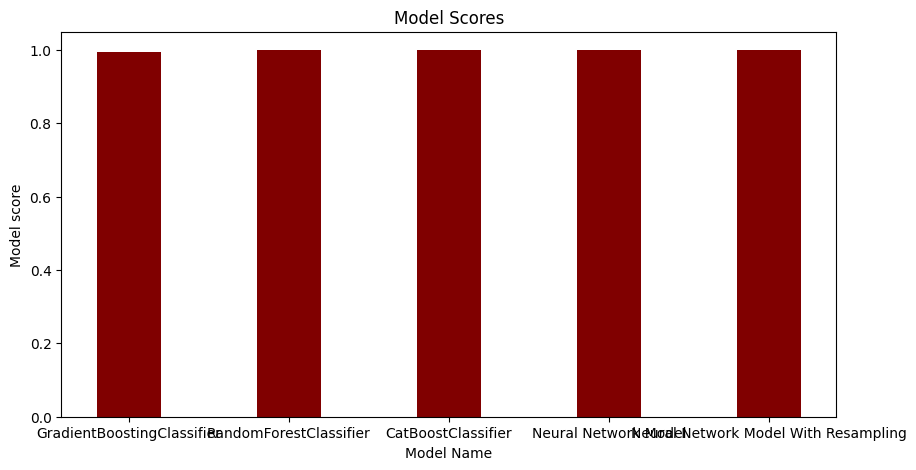

In [74]:
selectAndPlot(modelResult)


In [ ]:
import sklearn
print(sklearn.__version__)



1.5.1


In [1]:
import sys

# Print the path of the current Python interpreter
print("Python interpreter path:", sys.executable)

# Print the version of Python
print("Python version:", sys.version)

# Print the version info in a tuple format
print("Python version info:", sys.version_info)


Python interpreter path: /home/ibrahim/Desktop/ML Ops/myenv/bin/python
Python version: 3.12.3 (main, Jul 31 2024, 17:43:48) [GCC 13.2.0]
Python version info: sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
